<h1 class="font-effect-3d-float" style="color:firebrick; font-family:'Monoton'; ">Code Modules, Helpful Functions, Styling, and Links</h1>

[GitHub Repository](https://github.com/OlgaBelitskaya/deep_learning_projects/tree/master/DL_PP5) & [Colaboratory Version](https://colab.research.google.com/drive/1Tt3qZePsf2P6kNNao-hQ58DlG71Abj5a)

In [1]:
%%html
<style> 
@import url('https://fonts.googleapis.com/css?family=Monoton|Roboto&effect=3d-float|');
body {background-color:#f7e8e8;} 
a,h4 {color:crimson; font-family:Roboto;}
span {color:black; text-shadow:4px 4px 4px #aaa;}
div.output_prompt {color:crimson;} 
div.input_prompt {color:firebrick;} 
div.output_area pre,div.output_subarea {font-size:15px; color:crimson}
div.output_stderr pre {background-color:#f7e8e8;}
</style>

In [2]:
import warnings; warnings.filterwarnings('ignore')
import scipy,h5py,pandas as pd,numpy as np,pylab as pl
import seaborn as sn,keras as ks,tensorflow as tf
from scipy import misc
from skimage.transform import resize
from skimage import color,measure
from IPython.core.magic import register_line_magic
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
np.set_printoptions(precision=6)
pl.style.use('seaborn-whitegrid')
fpath='../input/traditional-decor-patterns/'
fw='weights.decor.hdf5'
n=np.random.choice(484,size=6,replace=False)
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential,load_model,Model
from keras.layers import Input,Activation,Dense,LSTM
from keras.layers import Flatten,Dropout,BatchNormalization
from keras.layers import Conv2D,MaxPooling2D,GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers.advanced_activations import PReLU,LeakyReLU
from keras.applications.resnet50 import \
ResNet50,preprocess_input as rn50pi
from keras.applications.inception_v3 import \
InceptionV3,preprocess_input as iv3pi
from keras.applications.xception \
import Xception,preprocess_input as xpi
from keras.applications.inception_resnet_v2 import \
InceptionResNetV2,preprocess_input as iv2pi
from keras import __version__
print('keras version:', __version__)
print('tensorflow version:',tf.__version__)

Using TensorFlow backend.


keras version: 2.1.5
tensorflow version: 1.7.0-rc1


In [3]:
def ohe(x): 
    return OneHotEncoder(n_values='auto')\
           .fit(x.reshape(-1,1))\
           .transform(x.reshape(-1,1))\
           .toarray().astype('int64')
def tts(X,y): 
    x_train,x_test,y_train,y_test=\
    train_test_split(X,y,test_size=.2,random_state=1)
    n=int(len(x_test)/2)
    x_valid,y_valid=x_test[:n],y_test[:n]
    x_test,y_test=x_test[n:],y_test[n:]
    return x_train,x_valid,x_test,y_train,y_valid,y_test
def history_plot(fit_history):
    pl.figure(figsize=(12,10)); pl.subplot(211)
    keys=list(fit_history.history.keys())[0:4]
    pl.plot(fit_history.history[keys[0]],
            color='crimson',label='train')
    pl.plot(fit_history.history[keys[2]],
            color='firebrick',label='valid')
    pl.xlabel("Epochs"); pl.ylabel("Loss")
    pl.legend(); pl.grid()
    pl.title('Loss Function')     
    pl.subplot(212)
    pl.plot(fit_history.history[keys[1]],
            color='crimson',label='train')
    pl.plot(fit_history.history[keys[3]],
            color='firebrick',label='valid')
    pl.xlabel("Epochs"); pl.ylabel("Accuracy")    
    pl.legend(); pl.grid()
    pl.title('Accuracy'); pl.show()

<h1 class="font-effect-3d-float" style="color:firebrick; font-family:'Monoton'; ">Data Preprocessing</h1>

In [4]:
data=pd.read_csv(fpath+'decor.csv')
f=h5py.File(fpath+'DecorColorImages.h5','r')
keys=list(f.keys())
[countries,decors,images,types]=\
[np.array(f[keys[i]]) for i in range(4)]
sh=[el.shape for el in [countries,decors,images,types]]
data.loc[n]

,country_label,country,decor_label,decor,type_label,type,file
260,1,Russia,3,Gorodets,2,product,01_03_2_042.png
259,1,Russia,3,Gorodets,2,product,01_03_2_041.png
75,1,Russia,1,Gzhel,2,product,01_01_2_043.png
244,1,Russia,3,Gorodets,2,product,01_03_2_026.png
443,3,Turkey,5,Iznik,1,product,03_05_2_038.png
181,1,Russia,2,Khokhloma,2,product,01_02_2_063.png


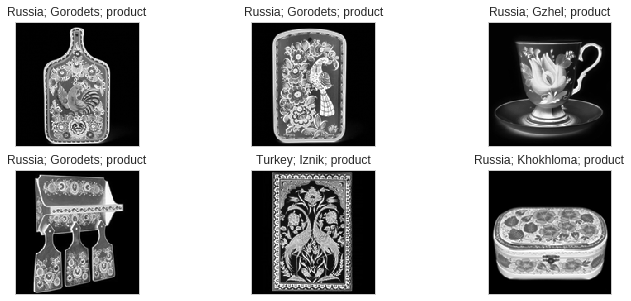

In [5]:
images=images/255
gray_images=np.dot(images[...,:3],[.299,.587,.114])
fig=pl.figure(figsize=(12,5))
for i,idx in enumerate(n):
    ax=fig.add_subplot(2,3,i+1,xticks=[],yticks=[])
    ax.imshow(gray_images[idx])
    ax.set_title(data['country'][idx]+'; '+\
                 data['decor'][idx]+'; '+data['type'][idx])

In [6]:
ccountries,cdecors,ctypes=\
ohe(countries),ohe(decors),ohe(types)
ctargets=np.concatenate((ccountries,cdecors),axis=1)
ctargets=np.concatenate((ctargets,ctypes),axis=1)
pd.DataFrame([images.shape,gray_images.shape,
              ccountries.shape,cdecors.shape,
              ctypes.shape,ctargets.shape])

,0,1,2,3
0,485,150,150.0,3.0
1,485,150,150.0,NaN
2,485,4,NaN,NaN
3,485,7,NaN,NaN
4,485,2,NaN,NaN
5,485,13,NaN,NaN


In [7]:
# spliting the data 
# Color Images / Countries 
x_train1,x_valid1,x_test1,\
y_train1,y_valid1,y_test1=tts(images,ccountries)
# Grayscaled Images / Countries 
x_train2,x_valid2,x_test2,\
y_train2,y_valid2,y_test2=tts(gray_images,ccountries)
# Color Images / Decors 
x_train3,x_valid3,x_test3,\
y_train3,y_valid3,y_test3=tts(images,cdecors)
# Grayscaled Images / Decors 
x_train4,x_valid4,x_test4,\
y_train4,y_valid4,y_test4=tts(gray_images,cdecors)
# Color Images / Multi-Label Targets
x_train5,x_valid5,x_test5,\
y_train5,y_valid5,y_test5=tts(images,ctargets)
# Grayscaled Images / Multi-Label Targets 
x_train6,x_valid6,x_test6,\
y_train6,y_valid6,y_test6=tts(gray_images,ctargets)
sh=[el.shape for el in \
[x_train1,y_train1,x_valid1,y_valid1,x_test1,y_test1,
 x_train3,y_train3,x_valid3,y_valid3,x_test3,y_test3,
 x_train5,y_train5,x_valid5,y_valid5,x_test5,y_test5,
 x_train2,y_train2,x_valid2,y_valid2,x_test2,y_test2,
 x_train4,y_train4,x_valid4,y_valid4,x_test4,y_test4,
 x_train6,y_train6,x_valid6,y_valid6,x_test6,y_test6]]
pd.DataFrame(sh)

,0,1,2,3
0,388,150,150.0,3.0
1,388,4,NaN,NaN
2,48,150,150.0,3.0
3,48,4,NaN,NaN
4,49,150,150.0,3.0
5,49,4,NaN,NaN
6,388,150,150.0,3.0
7,388,7,NaN,NaN
8,48,150,150.0,3.0
9,48,7,NaN,NaN


In [8]:
y_train5_list=[y_train5[:,:4],y_train5[:,4:11],y_train5[:,11:]]
y_test5_list=[y_test5[:,:4],y_test5[:,4:11],y_test5[:,11:]]
y_valid5_list=[y_valid5[:,:4],y_valid5[:,4:11],y_valid5[:,11:]]
y_train6_list=[y_train6[:,:4],y_train6[:,4:11],y_train6[:,11:]]
y_test6_list=[y_test6[:,:4],y_test6[:,4:11],y_test6[:,11:]]
y_valid6_list=[y_valid6[:,:4],y_valid6[:,4:11],y_valid6[:,11:]]

<h1 class="font-effect-3d-float" style="color:firebrick; font-family:'Monoton'; ">Classification Models</h1>
## ResNet50

In [9]:
# creating bottleneck features
resize_x_train3=np.array([scipy.misc.imresize(x_train3[i],(224,224,3)) 
                          for i in range(0,len(x_train3))]).astype('float32')
resize_x_valid3=np.array([scipy.misc.imresize(x_valid3[i],(224,224,3)) 
                          for i in range(0,len(x_valid3))]).astype('float32')
resize_x_test3=np.array([scipy.misc.imresize(x_test3[i],(224,224,3)) 
                          for i in range(0,len(x_test3))]).astype('float32')
x_train_bn3=rn50pi(resize_x_train3)
x_valid_bn3=rn50pi(resize_x_valid3)
x_test_bn3=rn50pi(resize_x_test3)
fn = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
resnet50base_model=\
ResNet50(weights=fn,include_top=False)
x_train_bn3=resnet50base_model.predict(x_train_bn3)
x_valid_bn3=resnet50base_model.predict(x_valid_bn3)
x_test_bn3=resnet50base_model.predict(x_test_bn3)

In [10]:
sh=x_train_bn3.shape[1:]
def resnet50_model():
    model=Sequential()
    model.add(GlobalAveragePooling2D(input_shape=sh))    
    model.add(Dense(2048))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.5))        
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.5))
    model.add(Dense(7, activation='softmax'))   
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',metrics=['accuracy'])
    return model
resnet50_model=resnet50_model()

In [11]:
checkpointer=ModelCheckpoint(filepath=fw,verbose=2,save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=10,
                               verbose=2,factor=.5)
estopping=EarlyStopping(monitor='val_loss',patience=16,verbose=2)
history=\
resnet50_model.fit(x_train_bn3,y_train3,
                   validation_data=(x_valid_bn3,y_valid3),
                   epochs=100,batch_size=128,verbose=2,
                   callbacks=[checkpointer,lr_reduction,estopping]);

Train on 388 samples, validate on 48 samples
Epoch 1/100
 - 2s - loss: 2.3362 - acc: 0.2835 - val_loss: 1.0843 - val_acc: 0.6875

Epoch 00001: val_loss improved from inf to 1.08428, saving model to weights.decor.hdf5
Epoch 2/100
 - 0s - loss: 1.0189 - acc: 0.6340 - val_loss: 0.6983 - val_acc: 0.8333

Epoch 00002: val_loss improved from 1.08428 to 0.69834, saving model to weights.decor.hdf5
Epoch 3/100
 - 0s - loss: 0.7675 - acc: 0.7294 - val_loss: 0.6776 - val_acc: 0.7083

Epoch 00003: val_loss improved from 0.69834 to 0.67759, saving model to weights.decor.hdf5
Epoch 4/100
 - 0s - loss: 0.8355 - acc: 0.7191 - val_loss: 0.4970 - val_acc: 0.7292

Epoch 00004: val_loss improved from 0.67759 to 0.49699, saving model to weights.decor.hdf5
Epoch 5/100
 - 0s - loss: 0.6948 - acc: 0.7835 - val_loss: 0.6276 - val_acc: 0.8333

Epoch 00005: val_loss did not improve
Epoch 6/100
 - 0s - loss: 0.5738 - acc: 0.8196 - val_loss: 0.4780 - val_acc: 0.8125

Epoch 00006: val_loss improved from 0.49699 to 

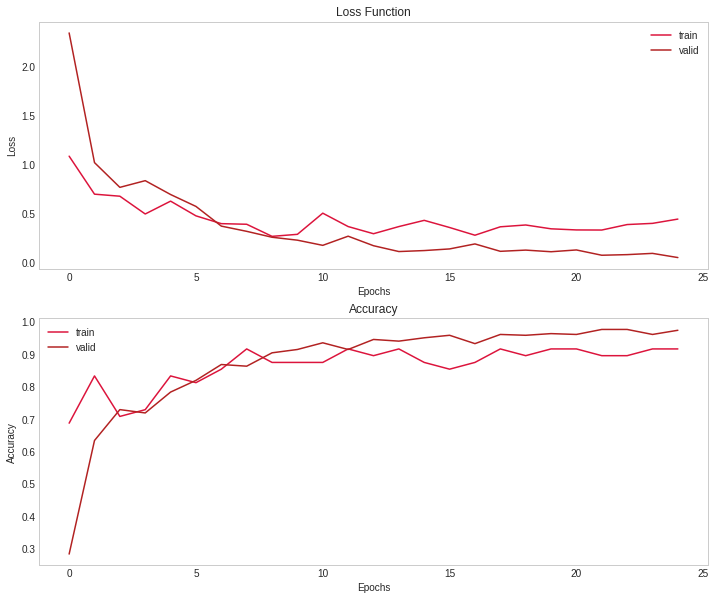

49/49 [==============================] - 0s 205us/step
Accuracy: 83.67%


[0.32487948269260175, 0.836734697526815]

In [12]:
history_plot(history)
resnet50_model.load_weights(fw)
resnet50_scores=resnet50_model.evaluate(x_test_bn3,y_test3)
print("Accuracy: %.2f%%"%(resnet50_scores[1]*100))
resnet50_scores

## Inception V3

In [13]:
resize_x_train1=np.array([scipy.misc.imresize(x_train1[i],(224,224,3)) 
                          for i in range(0,len(x_train1))]).astype('float32')
resize_x_valid1=np.array([scipy.misc.imresize(x_valid1[i],(224,224,3)) 
                          for i in range(0,len(x_valid1))]).astype('float32')
resize_x_test1=np.array([scipy.misc.imresize(x_test1[i],(224,224,3)) 
                         for i in range(0,len(x_test1))]).astype('float32')
x_train_bn1=iv3pi(resize_x_train1)
x_valid_bn1=iv3pi(resize_x_valid1)
x_test_bn1=iv3pi(resize_x_test1)
fn='../input/inceptionv3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
inceptionv3base_model=\
InceptionV3(weights=fn,include_top=False)
x_train_bn1=inceptionv3base_model.predict(x_train_bn1)
x_valid_bn1=inceptionv3base_model.predict(x_valid_bn1)
x_test_bn1=inceptionv3base_model.predict(x_test_bn1)

In [14]:
sh=x_train_bn1.shape[1:]
def inception_v3_model():
    model=Sequential()    
    model.add(GlobalAveragePooling2D(input_shape=sh))    
    model.add(Dense(2048))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.25))       
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.25))
    model.add(Dense(4,activation='softmax'))    
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',metrics=['accuracy'])
    return model
inception_v3_model=inception_v3_model()

In [15]:
checkpointer=ModelCheckpoint(filepath=fw,verbose=2,save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=5,
                               verbose=2,factor=.75)
estopping=EarlyStopping(monitor='val_loss',patience=16,verbose=2)
history=inception_v3_model.fit(x_train_bn1,y_train1,
                               validation_data=(x_valid_bn1,y_valid1),
                               epochs=100,batch_size=128,verbose=2,
                               callbacks=[checkpointer,lr_reduction,estopping]);

Train on 388 samples, validate on 48 samples
Epoch 1/100
 - 2s - loss: 3.1472 - acc: 0.3814 - val_loss: 1.8273 - val_acc: 0.5417

Epoch 00001: val_loss improved from inf to 1.82730, saving model to weights.decor.hdf5
Epoch 2/100
 - 0s - loss: 1.8676 - acc: 0.5722 - val_loss: 1.0286 - val_acc: 0.6458

Epoch 00002: val_loss improved from 1.82730 to 1.02861, saving model to weights.decor.hdf5
Epoch 3/100
 - 0s - loss: 1.1573 - acc: 0.6572 - val_loss: 0.9149 - val_acc: 0.6875

Epoch 00003: val_loss improved from 1.02861 to 0.91491, saving model to weights.decor.hdf5
Epoch 4/100
 - 0s - loss: 0.9152 - acc: 0.5851 - val_loss: 0.8340 - val_acc: 0.6458

Epoch 00004: val_loss improved from 0.91491 to 0.83396, saving model to weights.decor.hdf5
Epoch 5/100
 - 0s - loss: 0.7182 - acc: 0.7139 - val_loss: 0.6040 - val_acc: 0.7917

Epoch 00005: val_loss improved from 0.83396 to 0.60396, saving model to weights.decor.hdf5
Epoch 6/100
 - 0s - loss: 0.6155 - acc: 0.7474 - val_loss: 0.5518 - val_acc: 0.

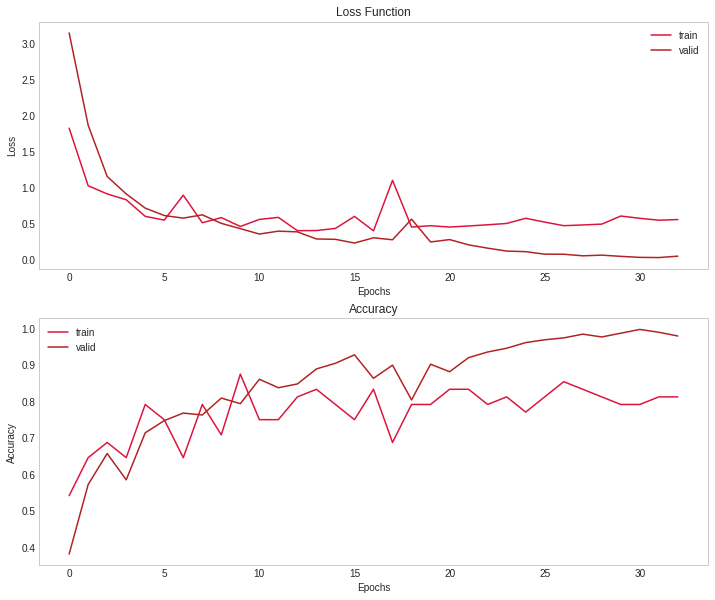

49/49 [==============================] - 0s 356us/step
Accuracy: 77.55%


[0.4945249435852985, 0.7755102101637392]

In [16]:
history_plot(history)
inception_v3_model.load_weights(fw)
inception_v3_scores=inception_v3_model.evaluate(x_test_bn1,y_test1)
print("Accuracy: %.2f%%" % (inception_v3_scores[1]*100))
inception_v3_scores

## Xception

In [17]:
resize_x_train3=np.array([scipy.misc.imresize(x_train3[i],(71,71,3)) 
                         for i in range(0,len(x_train3))]).astype('float32')
resize_x_valid3=np.array([scipy.misc.imresize(x_valid3[i],(71,71,3)) 
                           for i in range(0,len(x_valid3))]).astype('float32')
resize_x_test3=np.array([scipy.misc.imresize(x_test3[i],(71,71,3)) 
                         for i in range(0,len(x_test3))]).astype('float32')
x_train_bn3=xpi(resize_x_train3)
x_valid_bn3=xpi(resize_x_valid3)
x_test_bn3=xpi(resize_x_test3)
fn='../input/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5'
xceptionbase_model=Xception(weights=fn,include_top=False)
x_train_bn3=xceptionbase_model.predict(x_train_bn3)
x_valid_bn3=xceptionbase_model.predict(x_valid_bn3)
x_test_bn3=xceptionbase_model.predict(x_test_bn3)

In [18]:
sh=x_train_bn3.shape[1:]
def xception_model():
    model=Sequential()    
    model.add(GlobalAveragePooling2D(input_shape=sh))   
    model.add(Dense(2048))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.5))        
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.5))
    model.add(Dense(7, activation='softmax'))    
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',metrics=['accuracy'])
    return model
xception_model=xception_model()

In [19]:
checkpointer=ModelCheckpoint(filepath=fw,verbose=2,save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=5,
                               verbose=2,factor=.75)
estopping=EarlyStopping(monitor='val_loss',patience=16,verbose=2)
history=xception_model.fit(x_train_bn3,y_train3,
                           validation_data=(x_valid_bn3,y_valid3),
                           epochs=100,batch_size=128,verbose=2,
                           callbacks=[checkpointer,lr_reduction,estopping]);

Train on 388 samples, validate on 48 samples
Epoch 1/100
 - 2s - loss: 2.2985 - acc: 0.2113 - val_loss: 1.2554 - val_acc: 0.5833

Epoch 00001: val_loss improved from inf to 1.25541, saving model to weights.decor.hdf5
Epoch 2/100
 - 0s - loss: 1.1934 - acc: 0.5722 - val_loss: 1.1793 - val_acc: 0.4792

Epoch 00002: val_loss improved from 1.25541 to 1.17933, saving model to weights.decor.hdf5
Epoch 3/100
 - 0s - loss: 0.9268 - acc: 0.6778 - val_loss: 0.9970 - val_acc: 0.5417

Epoch 00003: val_loss improved from 1.17933 to 0.99702, saving model to weights.decor.hdf5
Epoch 4/100
 - 0s - loss: 0.8387 - acc: 0.7113 - val_loss: 1.2097 - val_acc: 0.5417

Epoch 00004: val_loss did not improve
Epoch 5/100
 - 0s - loss: 0.8147 - acc: 0.7216 - val_loss: 0.8441 - val_acc: 0.6458

Epoch 00005: val_loss improved from 0.99702 to 0.84411, saving model to weights.decor.hdf5
Epoch 6/100
 - 0s - loss: 0.6305 - acc: 0.7732 - val_loss: 0.8522 - val_acc: 0.7917

Epoch 00006: val_loss did not improve
Epoch 7/1

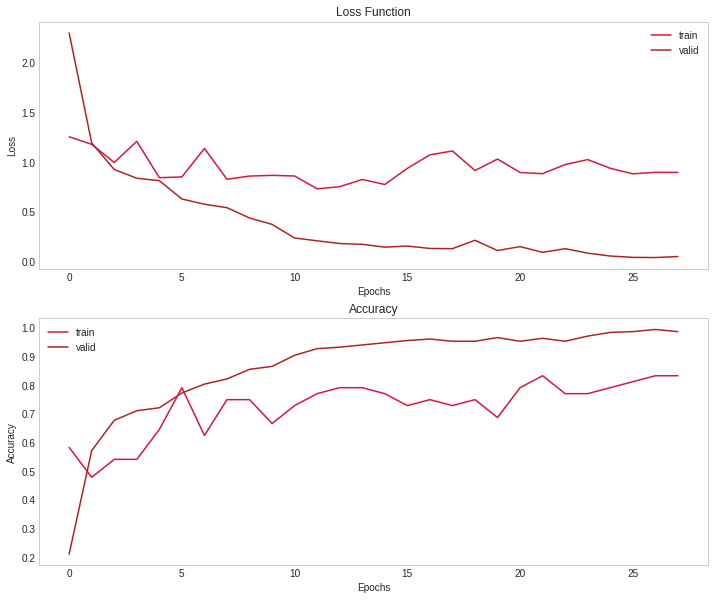

49/49 [==============================] - 0s 226us/step
Accuracy: 69.39%


[0.9955862857857529, 0.6938775595353575]

In [20]:
history_plot(history)
xception_model.load_weights(fw)
xception_scores=xception_model.evaluate(x_test_bn3,y_test3)
print("Accuracy: %.2f%%"%(xception_scores[1]*100))
xception_scores

## InceptionResNetV2

In [21]:
resize_x_train1=np.array([scipy.misc.imresize(x_train1[i],(139,139,3)) 
                          for i in range(0,len(x_train1))]).astype('float32')
resize_x_valid1=np.array([scipy.misc.imresize(x_valid1[i],(139,139,3)) 
                           for i in range(0,len(x_valid1))]).astype('float32')
resize_x_test1=np.array([scipy.misc.imresize(x_test1[i],(139,139,3)) 
                         for i in range(0,len(x_test1))]).astype('float32')
x_train_bn1=iv2pi(resize_x_train1)
x_valid_bn1=iv2pi(resize_x_valid1)
x_test_bn1=iv2pi(resize_x_test1)
fn='../input/inceptionresnetv2/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5'
inceptionresnetv2base_model=\
InceptionResNetV2(weights=fn,include_top=False)
x_train_bn1=inceptionresnetv2base_model.predict(x_train_bn1)
x_valid_bn1=inceptionresnetv2base_model.predict(x_valid_bn1)
x_test_bn1=inceptionresnetv2base_model.predict(x_test_bn1)

In [22]:
sh=x_train_bn1.shape[1:]
def inceptionresnetv2_model():
    model=Sequential()   
    model.add(GlobalAveragePooling2D(input_shape=sh))    
    model.add(Dense(2048))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.5))        
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.5))
    model.add(Dense(4,activation='softmax'))     
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',metrics=['accuracy'])
    return model
inceptionresnetv2_model=inceptionresnetv2_model()

In [23]:
checkpointer=ModelCheckpoint(filepath=fw,verbose=2,save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=5,
                               verbose=2,factor=.75)
estopping=EarlyStopping(monitor='val_loss',patience=16,verbose=2)
history=inceptionresnetv2_model\
.fit(x_train_bn1,y_train1,validation_data=(x_valid_bn1,y_valid1),
     epochs=100,batch_size=128,verbose=2,
     callbacks=[checkpointer,lr_reduction,estopping]);

Train on 388 samples, validate on 48 samples
Epoch 1/100
 - 6s - loss: 4.8102 - acc: 0.4562 - val_loss: 4.6486 - val_acc: 0.5000

Epoch 00001: val_loss improved from inf to 4.64859, saving model to weights.decor.hdf5
Epoch 2/100
 - 0s - loss: 4.2684 - acc: 0.5593 - val_loss: 4.3698 - val_acc: 0.5417

Epoch 00002: val_loss improved from 4.64859 to 4.36976, saving model to weights.decor.hdf5
Epoch 3/100
 - 0s - loss: 3.3653 - acc: 0.5670 - val_loss: 3.5775 - val_acc: 0.5000

Epoch 00003: val_loss improved from 4.36976 to 3.57748, saving model to weights.decor.hdf5
Epoch 4/100
 - 0s - loss: 2.8541 - acc: 0.6263 - val_loss: 3.1555 - val_acc: 0.5833

Epoch 00004: val_loss improved from 3.57748 to 3.15549, saving model to weights.decor.hdf5
Epoch 5/100
 - 0s - loss: 2.0615 - acc: 0.6675 - val_loss: 1.1229 - val_acc: 0.5833

Epoch 00005: val_loss improved from 3.15549 to 1.12288, saving model to weights.decor.hdf5
Epoch 6/100
 - 0s - loss: 1.6842 - acc: 0.5722 - val_loss: 0.7951 - val_acc: 0.

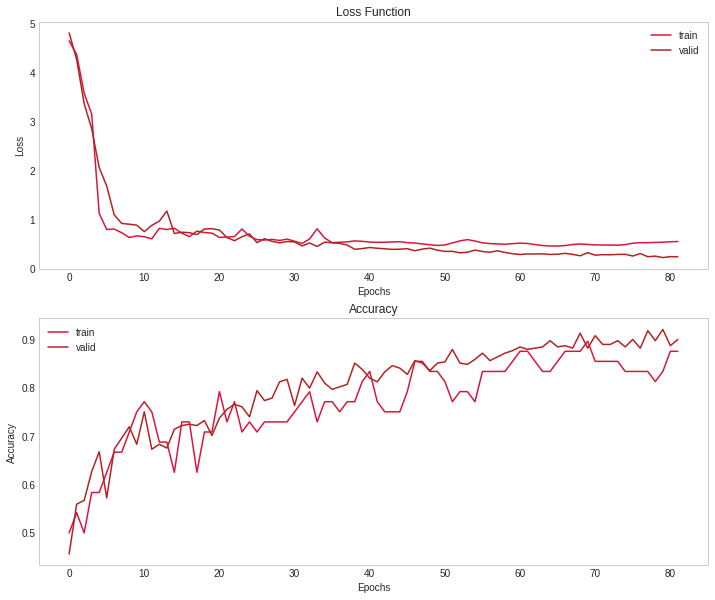

49/49 [==============================] - 0s 235us/step
Accuracy: 83.67%


[0.4799769070683693, 0.8367346999596577]

In [24]:
history_plot(history)
inceptionresnetv2_model.load_weights(fw)
inceptionresnetv2_scores=\
inceptionresnetv2_model.evaluate(x_test_bn1,y_test1)
print("Accuracy: %.2f%%"%(inceptionresnetv2_scores[1]*100))
inceptionresnetv2_scores